# Homework 3 - EECS 600 Deep Learning

Name: 

Instructions: All assignments are to be completed individually. Please complete each question as best you can. Once you have completed all of the problems, reset your runtime or kernel and run the notebook in order. Download the .ipynb file and submit it via Canvas.

Library usage: Several of the algorithms implemented in this, and other assignments, have implementations available in tensorflow. For this assignment, you may use any of the functionality within tensorflow.

All code presented in class is free to use in your assignments.

Your grade is based on the correctness of your implementation, not the quality of your code but you are encouraged to include comments in your code to help the graders understand your decisions.

For clarity, the final operation you should take is restarting the runtime and running all.

Due Date: 12/6/19 - midnight EST

100 Points Total

In [0]:
#For this question, the reference is given in the class:
#https://www.tensorflow.org/tutorials/generative/dcgan. 
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
# To generate GIFs
!pip install -q imageio

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import layers
tf.enable_eager_execution()
import os
import time
import glob
import imageio
import PIL
from IPython import display
#Grant the access and mount the drive
from google.colab import drive
drive.mount('/content/gdrive')
print("TensorFlow version: {}".format(tf.__version__))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
TensorFlow version: 1.15.0


In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape)
print(train_labels[0])

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
9


Loading the dataset returns four NumPy arrays:

The train_images and train_labels arrays are the training set—the data the model uses to learn.
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

Label |	Class
------|------
0 |	T-shirt/top
1 |	Trouser
2 |	Pullover
3 |	Dress
4 |	Coat
5 |	Sandal
6 |	Shirt
7 |	Sneaker
8 |	Bag
9 |	Ankle boot

Each image is mapped to a single label. Since the class names are not included with the dataset.

More information and a working example using this dataset here: https://www.tensorflow.org/tutorials/keras/classification.

## Recommendation
When building and testing your code, work on a smaller subset of the data. [This example](https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array) may help in that.


# Question 1
Implement a Deep Convolutional Generative Adversarial Network for generating fasion MNIST photos.

In [0]:
#preprocess the dataset
#The images are black and white, must add an additional channel dimension to transform them to be three
#dimensional
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]


In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
#The generator part
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    #Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument
    #Here no activation is applied
    #output arrays of shape (None,12544) None is the batch size
    model.add(layers.BatchNormalization())
    #batch normalization layer
    #normalize the activations of the previous layer at each batch,
    #(None,12544)
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation 
    #standard deviation close to 1
    model.add(layers.LeakyReLU())
    #It allows a small gradient when the unit is not active: f(x) = alpha * x for x < 0, f(x) = x for x >= 0
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #same results in padding the inpyt such that output has the same length as the original input

    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #It is like a layer that combines the UpSampling2D and Conv2D layers into one layer
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)


    return model


tf.Tensor(
[[-1.2511084  -0.2907497  -0.6354276  -2.1702087  -0.7893085  -0.11765523
  -0.9017894  -0.46143922  0.04251894  0.19624196 -0.6717362  -0.08144298
  -0.05721562 -0.9626788  -0.26699966 -0.47461146  1.2070478   0.44105676
  -2.3801048  -0.21702248 -0.50575525  1.0984397  -0.5459532   0.25978976
  -0.6144541   1.0201269  -0.11944397 -1.885078    0.32252854 -0.39888474
   0.25540295  0.57348543 -0.43570548  1.2531585  -0.01545737 -2.453495
   0.72890806  0.42527384 -2.2018628  -0.79977304  0.811498   -0.00964605
   1.0146042  -1.1954978  -0.92771626  0.7624016   0.51208264  0.8230632
  -0.48415768  0.39286917  0.8228257   0.47349477  2.8845007   0.03006286
   1.6901126  -2.1074185   0.51547307 -0.53840786 -0.6890511  -0.33234468
  -0.2720782  -0.29968274  0.45504406 -1.2086502  -1.1793591   0.05499498
   0.4257317   0.32532158 -0.45615613  0.1713939   0.89324033  0.26142284
   0.1485169   0.71476585 -2.2286315   0.09506568 -0.99376184 -0.9363976
  -0.35704255  0.73980135 -0.00

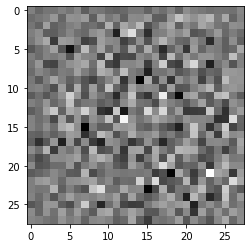

In [0]:
generator = make_generator_model()
#generator.summary()

noise = tf.random.normal([1, 100])
print(noise)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    model.gen_loss_result=[]
    model.disc_loss_result=[]

    return model

In [0]:
discriminator = make_discriminator_model()
#discriminator.summary()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00092956]], shape=(1, 1), dtype=float32)


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# save checkpoints, save and restore models in case training task is interrupted
checkpoint_dir = F'/content/gdrive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images,current_step):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      #print(real_output.numpy())
      fake_output = discriminator(generated_images, training=True)
      #print(fake_output.numpy())
      gen_loss = generator_loss(fake_output)
      print(f'current step is {current_step}')
      print(f'gen_loss is {gen_loss.numpy():0.4f}')
      disc_loss = discriminator_loss(real_output, fake_output)
      print(f'disc_loss is {disc_loss.numpy():0.4f}')

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    step_gen_loss = gen_loss.numpy()
    step_disc_loss = disc_loss.numpy()
    return step_gen_loss, step_disc_loss


In [0]:
def plotLoss(gen_loss_result,disc_loss_result):
  epoch_count = range(1, len(gen_loss_result) + 1)
  plt.plot(epoch_count, gen_loss_result, 'r-')
  plt.plot(epoch_count, disc_loss_result, 'b--')
  plt.legend(['Generator Loss', 'Discriminator Loss'])
  plt.title('Two losses in GANs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show();

In [0]:
def train(dataset, epochs):

  gen_loss_result =[]
  disc_loss_result = []
  for epoch in range(epochs):
    start = time.time()

    current_step =0
    batch_step_gen_loss =[]
    batch_step_disc_loss = []
    for image_batch in dataset:
      #print("image_batch shape is")
      #print(image_batch.shape)
      step_gen_loss, step_disc_loss = train_step(image_batch,current_step)
      current_step+=1
      batch_step_gen_loss.append(step_gen_loss)
      batch_step_disc_loss.append(step_disc_loss)
      #print(f'batch_step_gen_loss length is {len(batch_step_gen_loss)}')
      #print(f'batch_step_disc_loss length is {len(batch_step_disc_loss)}')
    epoch_mean_gen_loss = np.mean(batch_step_gen_loss)
    epoch_mean_disc_loss = np.mean(batch_step_disc_loss)
    print('Current epoch {} is'.format(epoch+1))

    gen_loss_result.append(epoch_mean_gen_loss)
    disc_loss_result.append(epoch_mean_disc_loss)

    '''
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    '''
    discriminator.gen_loss_result = gen_loss_result
    discriminator.disc_loss_result = disc_loss_result
    #print('gen_loss_result length is {}'.format(len(discriminator.gen_loss_result)))
    #print('disc_loss_result length is {}'.format(len(discriminator.disc_loss_result)))
    print(f'The gen_loss value for epoch {epoch+1} is {epoch_mean_gen_loss:0.4f}')
    print(f'The disc_loss value for epoch {epoch+1} is {epoch_mean_disc_loss:0.4f}')

    # Save the model every 15 epochs
    # Here we set epcochs as 15 since we have a pre-trained model that has 15 epochs for this assignment
    # Just in case we have a backup pre-trained model, but cannot evaluate the loss info
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  #plotLoss(gen_loss_result,disc_loss_result)
  '''
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  '''
  return gen_loss_result, disc_loss_result

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
gen_loss_result, disc_loss_result=train(train_dataset, EPOCHS)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
current step is 0
gen_loss is 0.6952
disc_loss is 1.3527
current step is 1
gen_loss is 0.6762
disc_loss is 1.3387
current step is 2
gen_loss is 0.6573
disc_loss is 1.3302
current step is 3
gen_loss is 0.6400
disc_loss is 1.3111
current step is 4
gen_loss is 0.6246
disc_loss is 1.3060
current step is 5
gen_loss is 0.6119
disc_loss is 1.2917
current step is 6
gen_loss is 0.5979
disc_loss is 1.2809
current step is 7
gen_loss is 0.5923
disc_loss is 1.2631
current step is 8
gen_loss is 0.5898
disc_loss is 1.2443
current step is 9
gen_loss is 0.5828
disc_loss is 1.2255
current step is 10
gen_loss is 0.5813
disc_loss is 1.2009
current step is 11
gen_loss is 0.5817
disc_loss is 1.1904
current step is 12
gen_loss is 0.5761
disc_loss is 1.1773
current step is 13
gen_loss is 0.5749
disc_loss is 1.1590
current step is 14
gen_loss is 0.5710
disc_loss is 1.1484
current step is 15
gen_loss is 0.5644
disc_los

In [0]:
#save all the images during the training/testing epochs
#from google.colab import files
#for epoch in range(1,16):
  #files.download('image_at_epoch_{:04d}.png'.format(epoch))

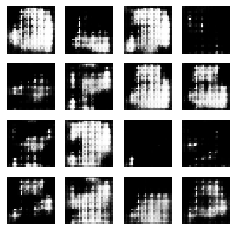

In [0]:
epochs = 10
display.clear_output(wait=True)
generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

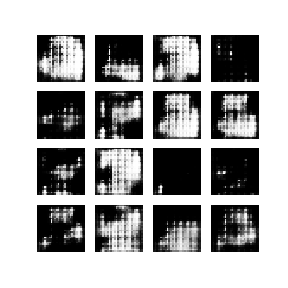

In [0]:
display_image(EPOCHS)

In [0]:
'''
#save all training generated images as a gif
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)
'''

In [0]:
'''
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)
'''

Plot the loss functions for the generator and discriminator. Label them accordingly.

In [0]:
#Just in case training is interrupted, use pretrained model to plot loss 
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

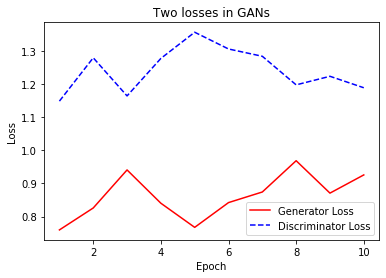

In [0]:
plotLoss(gen_loss_result,disc_loss_result)

Show three example generated photos using your model. Even though the images may not be perfect, it should be perceivable as a fashion photo.

In [0]:
#Restore the latest checkpoint
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
# generate images
num_examples_to_generate =3 
noise_dim =100
latent_points = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
def generate_and_save_3images(model, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(1, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

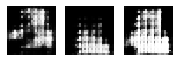

In [0]:
 display.clear_output(wait=True)
 generate_and_save_3images(generator,
                          latent_points)

# Question 2
Design a method to conditionally generate photos of different labels. Pick two classes within the MNIST fasion dataset, and use them to conditionally generate photos of those two classes. You will likely need to include another outcome variable in the discriminator to account for this.

Plot all of your loss functions and label them accordingly. 

In [0]:
#For this question, we need to design models in Keras to have multiple inputs
#We choose to use Functional API
#Reference: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
fashion_mnist = tf.keras.datasets.fashion_mnist

In [0]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

In [0]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

tf.compat.v1.disable_eager_execution()

Using TensorFlow backend.


In [0]:
# Define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In [0]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
  # compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


In [0]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = fashion_mnist.load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

In [0]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [0]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
  d_model.trainable = False
	# get noise and label inputs from generator model
  gen_noise, gen_label = g_model.input
  # get image output from the generator model
  gen_output = g_model.output
  # connect image output and label input from generator as inputs to discriminator
  gan_output = d_model([gen_output, gen_label])
  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_noise, gen_label], gan_output)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [0]:
def plotLoss(gen_loss_result,disc_loss_result):
  epoch_count = range(1, len(gen_loss_result) + 1)
  plt.plot(epoch_count, gen_loss_result, 'r-')
  plt.plot(epoch_count, disc_loss_result, 'b--')
  plt.legend(['Generator Loss', 'Discriminator Loss'])
  plt.title('Two losses in GANs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show();

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  gen_loss_result =[]
  disc_loss_result = []
  # manually enumerate epochs
  for i in range(n_epochs):
    batch_step_gen_loss =[]
    batch_step_disc_loss = []
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      d_loss = d_loss1 + d_loss2
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' %
      (i+1, j+1, bat_per_epo, d_loss, g_loss))
      batch_step_gen_loss.append(g_loss)
      batch_step_disc_loss.append(d_loss)
    epoch_mean_gen_loss = np.mean(batch_step_gen_loss)
    epoch_mean_disc_loss = np.mean(batch_step_disc_loss)
    gen_loss_result.append(epoch_mean_gen_loss)
    disc_loss_result.append(epoch_mean_disc_loss)
  plotLoss(gen_loss_result,disc_loss_result)
  # save the generator model
  model_save_name = 'cgan_generator.h5'
  path = F"/content/gdrive/My Drive/{model_save_name}" 
  g_model.save(path)

In [0]:
dataset = load_real_samples()
#[X_real, labels_real], y_real = generate_real_samples(dataset, 256)
#print([X_real.shape, labels_real])
#print(y_real.shape)

In [0]:
discriminator_cgan = define_discriminator()
#discriminator.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
# size of the latent space
latent_dim = 100
# create the generator
generator_cgan = define_generator(latent_dim)

In [0]:
# create the gan
gan_model = define_gan(generator_cgan, discriminator_cgan)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/234, d=1.398, g=0.692


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/234, d=1.324, g=0.688
>1, 3/234, d=1.268, g=0.682
>1, 4/234, d=1.214, g=0.672
>1, 5/234, d=1.170, g=0.661
>1, 6/234, d=1.144, g=0.644
>1, 7/234, d=1.131, g=0.630
>1, 8/234, d=1.121, g=0.625
>1, 9/234, d=1.115, g=0.642
>1, 10/234, d=1.028, g=0.702
>1, 11/234, d=0.985, g=0.787
>1, 12/234, d=0.902, g=0.870
>1, 13/234, d=0.886, g=0.902
>1, 14/234, d=0.884, g=0.884
>1, 15/234, d=0.882, g=0.840
>1, 16/234, d=0.921, g=0.789
>1, 17/234, d=0.948, g=0.740
>1, 18/234, d=0.982, g=0.685
>1, 19/234, d=1.076, g=0.611
>1, 20/234, d=1.129, g=0.576
>1, 21/234, d=1.133, g=0.595
>1, 22/234, d=1.035, g=0.680
>1, 23/234, d=0.871, g=0.870
>1, 24/234, d=0.655, g=1.119
>1, 25/234, d=0.547, g=1.231
>1, 26/234, d=0.546, g=1.154
>1, 27/234, d=0.593, g=1.002
>1, 28/234, d=0.685, g=0.856
>1, 29/234, d=0.764, g=0.747
>1, 30/234, d=0.808, g=0.681
>1, 31/234, d=0.873, g=0.640
>1, 32/234, d=0.900, g=0.614
>1, 33/234, d=0.924, g=0.602
>1, 34/234, d=0.928, g=0.602
>1, 35/234, d=0.919, g=0.618
>1, 36/234, d=0.913, g

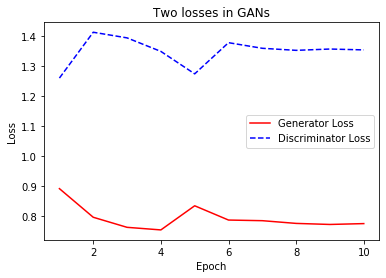

In [0]:
#train model
train(generator_cgan, discriminator_cgan, gan_model, dataset, latent_dim)

In [0]:
  model_save_name = 'cgan_generator.h5'
  path = F"/content/gdrive/My Drive/training_checkpoints"
  checkpoint_prefix = os.path.join(path, model_save_name) 
  generator_cgan.save(checkpoint_prefix)

In [0]:
def generate_and_save_3images(model, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(1, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

Show three examples of photos generated of your first class.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Select first label as 8


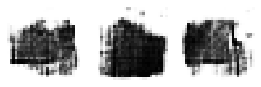

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(X.shape[0]):
		# define subplot
		pyplot.subplot(1, 4, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model(checkpoint_prefix)
# generate images
latent_points, labels = generate_latent_points(100, 3)
#print(latent_points.shape[0])
# specify labels 8
print("Select first label as 8")
labels = np.ones(3)*8
#print (labels)
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

Show three examples of photos generated of your second class.

In [0]:
# load model if somehow the training is interrupted
model = load_model(checkpoint_prefix)
# generate images
latent_points, labels = generate_latent_points(100, 3)
print(latent_points.shape[0])
# specify labels 6
print("Select second label as 6")
labels = np.ones(3)*6
#print (labels)
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


3
Select second label as 6


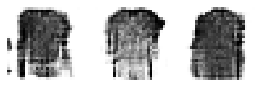

In [0]:
# load model
model = load_model(checkpoint_prefix)
# generate images
latent_points, labels = generate_latent_points(100, 3)
print(latent_points.shape[0])
# specify labels 6
print("Select second label as 6")
labels = np.ones(3)*6
#print (labels)
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)